# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

TO-DO liste

1.INITIALISATION


2.FILTRAGE (paramètres fixes)
Fixer à la main les paramètres sans s'occuper de l'initialisation


3.PREDICTION (paramètres fixes)

4.PMCMC (paramètres refités à chaque nouvelle prédiction)
    




In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

In [2]:
#import pymc
#from pymc import MCMC

### Parameters

In [3]:
n0=365 #Initialisaion sample
M=10**3 #number of particles
n_pred=48  #number of predictions
N_daytype=8  #number of day types
burnin_halfhour=1000  #burnin period in 30min interval [OPTION C]
burnin_days=28 #burnin period in # of days  [OPTION C]

In [4]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5
    R=sum((M*w_h).astype(int))
    if R>M:
        return(print("weights are too heavy"))
    z=np.zeros(M)
    z[:R-1]=x_h[:R-1]
    w_=(M*w_h-(M*w_h).astype(int))/(M-R-1)
    z[R:]=sum(w_)
    return(z)

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [5]:
#test the functions on random sample
#resid_resample(npr.normal(size=10),np.repeat(0.1,10))

In [6]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([-1.03649283, -0.9906    ,  0.17866311, -0.67930168, -1.22615444,
       -0.60623059,  0.52763558,  0.19653669, -0.24059902, -1.36047582])

### Load temperatures data

In [7]:
df_temp=pd.read_csv('data/temp_2016.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,t,hour
1707,2016-01-01,9.044444,09:00
1710,2016-01-01,11.005556,18:00
1709,2016-01-01,11.437736,15:00
1708,2016-01-01,11.196296,12:00
1711,2016-01-01,10.683333,21:00


In [8]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
T_h=list(temp_day.t)

### Load electricity data

In [9]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df.index=range(0,len(df))

In [10]:
df.head()

,Unnamed: 0,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype0,daytype1,daytype2,daytype3,daytype4,daytype6,daytype5,daytype7,daytype8,daytype
0,0,2009-06-06T06:00:00+02:00,2009-06-06,06:00,35984,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
1,1,2009-06-06T09:00:00+02:00,2009-06-06,09:00,43188,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
2,2,2009-06-06T11:30:00+02:00,2009-06-06,11:30,46959,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
3,3,2009-06-06T12:30:00+02:00,2009-06-06,12:30,48622,DÃ©finitive,False,False,True,False,False,False,False,False,False,2
4,4,2009-06-06T20:30:00+02:00,2009-06-06,20:30,42578,DÃ©finitive,False,False,True,False,False,False,False,False,False,2


In [11]:
df=df.sort_values(by=['Date'])
df.index=range(0,len(df))
#Valeurs intermédiaires à partir de 2017

In [12]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]
df.index=range(0,len(df))

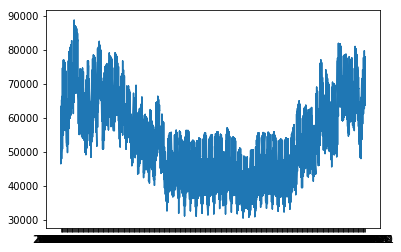

In [13]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

In [14]:
#try a different approach: consider 2pm daily time series
df_day=df[df.Heure=='15:00']
y_n=df_day['Consommation (MW)']
y_n=y_n[:burnin_days]

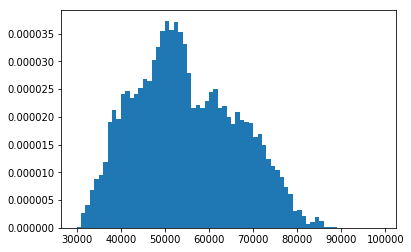

In [15]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

In [ ]:
#Add a bit of noise with uniform random
s=8000*np.ones(M)*npr.uniform(0.5,1.5,size=M)
g_h=-8000*np.ones(M)*npr.uniform(0.5,1.5,size=M)
sigma2=10**5*np.ones(M)*npr.uniform(0.5,1.5,size=M)
sigma2_g_star=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma2_s_star=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma2_g=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma2_s=(10**5)*npr.uniform(0.5,1.5,size=M)

k_day=npr.dirichlet(np.ones(N_daytype),1)[0]
u_h=14 #mean of N(14,1)

### Option B: generate initial parameters based on prior distribution

In [ ]:
sigma2=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
g_h = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)

u_h=npr.normal(14,1)  #fixed parameter, invariant to time
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]

C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)


#### --> Calculate x and w at initial state based on initial parameters

In [ ]:
#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

daytype_init=1
day_init=1

#Calculate x0 and w0 before filtering
x_season[0,:]=k_day[daytype_init]*s
if T_h[day_init]-u_h >0:
    x_heat[0,:]=g_h*(T_h[day_init]-u_h)*1
else:
    x_heat[0,:]=np.zeros(M)

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now
w0_=x_0+npr.normal(0,sigma2,size=M)  #compute w_wave = g(y_0 l X_0)

### 2.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [186]:
import math
w =np.zeros([n_pred+1,M])  #initalize matrix of weights w
w0_h=w0_/sum(w0_)   #set w_hat
ESS_0=1/(sum(w0_h)**2)  #calculate ESS
if math.isnan(ESS_0):
    ESS_0=1
print(ESS_0)
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w[0,:]=w0_

### Option C: MCMC using MHA or Gibbs (TBA)

In [16]:
import numpy as np
from scipy.stats import truncnorm, invgamma
import math

In [17]:
df['Consommation']=df['Consommation (MW)']*10**6
df.head()

,Unnamed: 0,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype0,daytype1,daytype2,daytype3,daytype4,daytype6,daytype5,daytype7,daytype8,daytype,Consommation
0,149461,2016-01-02T09:00:00+01:00,2016-01-02,09:00,52975,DÃ©finitive,False,False,True,False,False,False,False,True,True,8,52975000000
1,149460,2016-01-02T07:00:00+01:00,2016-01-02,07:00,49417,DÃ©finitive,False,False,True,False,False,False,False,True,True,8,49417000000
2,149462,2016-01-02T10:00:00+01:00,2016-01-02,10:00,55737,DÃ©finitive,False,False,True,False,False,False,False,True,True,8,55737000000
3,149463,2016-01-02T11:00:00+01:00,2016-01-02,11:00,57237,DÃ©finitive,False,False,True,False,False,False,False,True,True,8,57237000000
4,149464,2016-01-02T13:00:00+01:00,2016-01-02,13:00,61223,DÃ©finitive,False,False,True,False,False,False,False,True,True,8,61223000000


In [18]:
#df[df['Heure']=='14:00'][['Date', 'Consommation (MW)', 'daytype']][:30]
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])
temperature_ts = T_h[:30] #france mean temp in jan 2016
daytype_ts = list(df[df['Heure']=='15:00']['daytype'][:30])

In [22]:
def pf_init_gibbs(temperature_list, daytype_list, consumption_list, init_iterations, nb_particles, sigma2, kappa, u_heat, log):
    """
    Parameters :
    temperature_list: list of temperatures (per day)
    daytype_list: list of daytypes (per day)
    consumption_list: list of electricity consumption (per day)
    init_iterations: number of iterations for the initialization step
    nb_particles: number of particles
    sigma2: initial sigma squared (fixed)
    kappa: 
    u_heat: 
    log: if True returns value of the computed parameters during the sampling
    """
    # Variables initialization
    s = np.zeros((init_iterations, nb_particles)) 
    g_heat = np.zeros((init_iterations, nb_particles))
    #sigma_s and sigma_g are fixed
    sigma_s_star_2 = np.zeros((1, nb_particles)) 
    sigma_g_star_2 = np.zeros((1, nb_particles))

    #Gibbs : Initialization
    s[0,0] = truncnorm.rvs(a = 0,b = math.inf, loc= 0, scale = 10**4, size=1)[0]
    g_heat[0,0] =  truncnorm.rvs(a = - math.inf,b = 0, loc= 0, scale = 10**4, size=1)[0]
    sigma_s_star_2[0, 0] = invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
    sigma_g_star_2[0, 0] = invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
    
    #Gibbs : Step 0
    sigma_s_star0 = math.sqrt(sigma_s_star_2[0,0])
    sigma_g_star0 = math.sqrt(sigma_g_star_2[0,0])
    for i in range(1, init_iterations):
        s[i,0] = s[i-1,0] + \
                 truncnorm.rvs(a = -s[i-1,0]/sigma_s_star0,b = math.inf, loc= 0, scale = sigma_s_star0, size=1)[0] #page 18
        g_heat[i,0] = g_heat[i-1,0] + \
                      truncnorm.rvs(a = -math.inf, b=- g_heat[i-1,0]/sigma_g_star0, loc= 0, scale = sigma_g_star0, size=1)[0]
    
    #Gibbs : step t > 0
    for j in range(1, nb_particles):
        if log:
            print("Particle " + str(j) + "/" + str(nb_particles))
        else:
            if(j%10**4==0):
                print("Particle " + str(j) + "/" + str(nb_particles))
        s[:,j] = s[:,j-1]
        g_heat[:,j] = g_heat[:,j-1]
        sigma_s_star_2[:,j] = sigma_s_star_2[:,j-1]
        sigma_g_star_2[:,j] = sigma_g_star_2[:,j-1]
        
        # Simulate s0
        #Compute variance and mean denominator
        denom_s_0 = (10**4)*sigma_s_star_2[0, j]*(kappa[daytype_list[0]]**2) + sigma2*sigma_s_star_2[0, j] + (10**8)*sigma2 
        #Compute mean numerator
        numerator_mean_s_0 = (10**4)*sigma2* s[1,j] + (10**8)*sigma_s_star_2[0, j]*kappa[daytype_list[0]]*consumption_list[0]
        if (u_heat > temperature_list[0]):
            numerator_mean_s_0 -= (10**4)*sigma_s_star_2[0, j]*kappa[daytype_list[0]]*g_heat[0,j]*(temperature_list[0] - u_heat)
        #Compute the final parameters of the truncated normal that simulates from the full conditional of s_0
        #Mean
        mean_s_0 = numerator_mean_s_0 / denom_s_0
        #Variance
        var_s_0 = ((10**8) *sigma2*sigma_s_star_2[0, j]) / denom_s_0
        std_s_0 = math.sqrt(var_s_0)

        a=-mean_s_0/std_s_0
        while True:
            s[0,j] = truncnorm.rvs(a = a, b = math.inf, loc= mean_s_0, scale = std_s_0, size=1)[0]
            if(s[0,j]!=math.inf):
                break
        if log:
            print("s[0,"+str(j)+"]")
            print(s[0,j])
        
        # Simulate s(i), i>0
        for i in range(1, init_iterations):
            denom_s_i = 2*sigma2 + sigma_s_star_2[0, j]*(kappa[daytype_list[i]]**2)
            dependence_next_s = 0
            if (i+1 < init_iterations-1):
                dependence_next_s = s[i+1,j]
            #Compute mean numerator
            numerator_mean_s_i = sigma2*(s[i-1,j] + dependence_next_s) + \
                                 sigma_s_star_2[0, j]*kappa[daytype_list[i]]*(consumption_list[i])
            if (u_heat > temperature_list[i]):
                numerator_mean_s_i = numerator_mean_s_i - \
                                     sigma_s_star_2[0, j]*kappa[daytype_list[i]]*g_heat[i,j]*(temperature_list[i] - u_heat)
            mean_s_i = numerator_mean_s_i / denom_s_i
            var_s_i = (sigma2*sigma_s_star_2[0, j]) / denom_s_i
            std_s_i = math.sqrt(var_s_i)
            
            a=-mean_s_i/std_s_i
            temp=0
            while True:
                s[i,j] = truncnorm.rvs(a = a, b = math.inf, loc= mean_s_i, scale = std_s_i, size=1)[0]
                if(s[i,j]!=math.inf and s[i,j]!=-math.inf):
                    break
                
                temp+=1
                if(temp%5==0):
                    print(temp)
            if log:
                print("s["+str(i)+","+str(j)+"]")
                print(s[i,j])
        
        # Simulate g_heat0
        denom_g_0 = sigma2*sigma_g_star_2[0, j] + (10**8)*sigma2
        numerator_mean_g_0 = (10**8)*sigma2* g_heat[1,j]
        if (u_heat > temperature_list[0]):
            denom_g_0 = denom_g_0 + (10**8)*sigma_g_star_2[0, j]*((temperature_list[0] - u_heat )**2)
            numerator_mean_g_0 = numerator_mean_g_0 + \
                                 (10**8)*sigma_g_star_2[0, j]*(temperature_list[0] - u_heat)*(consumption_list[0] - s[0,j]*kappa[daytype_list[0]])
        #Compute the final parameters of the truncated normal that simulates from the full conditional of g_0
        mean_g_0 = numerator_mean_g_0 / denom_g_0
        var_g_0 = ((10**8) *sigma2*sigma_g_star_2[0, j]) / denom_g_0
        std_g_0 = math.sqrt(var_g_0)

        b=-mean_g_0/std_g_0
        while True:
            g_heat[0,j] =  truncnorm.rvs(a = -math.inf, b = b, loc= mean_g_0, scale = std_g_0, size=1)[0]
            if(g_heat[0,j]!=-math.inf):
                break
        if log:
            print("g_heat["+str(0)+","+str(j)+"]")
            print(g_heat[0,j])

        # Simulate g_heat(i), i>0
        for i in range(1, init_iterations):
            dependence_next_g = 0
            if (i+1 < init_iterations-1):
                dependence_next_g = g_heat[i+1,j]

            denom_g_i = 2*sigma2
            numerator_mean_g_i = sigma2*(g_heat[i-1,j] + dependence_next_g)
            if (u_heat > temperature_list[i]):
                denom_g_i = denom_g_i + sigma_g_star_2[0, j]*((temperature_list[i] - u_heat )**2)
                numerator_mean_g_i = numerator_mean_g_i + \
                                     sigma_g_star_2[0, j]*(temperature_list[i] - u_heat )*(consumption_list[i] - s[i,j]*kappa[daytype_list[i]])

            mean_g_i = numerator_mean_g_i / denom_g_i
            var_g_i = (sigma2*sigma_g_star_2[0, j]) / denom_g_i
            std_g_i = math.sqrt(var_g_i)

            b=-mean_g_i/std_g_i
            while True:
                g_heat[i,j] =  truncnorm.rvs(a = -math.inf, b = b, loc= mean_g_i, scale = std_g_i, size=1)[0]
                if(g_heat[i,j]!=-math.inf):
                    break
            if log:
                print("g_heat["+str(i)+","+str(j)+"]")
                print(g_heat[i,j])

        # Simulate the variances
        shape_variances = 0.01 + ((init_iterations - 1)/2)
        s_lag = np.roll(s[:,j], 1)
        s_lag[0] = s[0,j]
        scale_s = (0.01 + sum((s[:,j] - s_lag)**2))**(-1)
        sigma_s_star_2[0, j] = invgamma.rvs(a=shape_variances, scale=scale_s, size = 1)[0]
        g_lag = np.roll(g_heat[:,j], 1)
        g_lag[0] = g_heat[0,j]
        scale_g = (0.01 + sum((g_heat[:,j] - g_lag)**2))**(-1)
        sigma_g_star_2[0, j] = invgamma.rvs(a=shape_variances, scale=scale_g, size = 1)[0]

        if log:
            print(s[:,j])
            print(g_heat[:,j])

    # Return the initialization of the Particle Filter at date (init_iterations - 1)
    s_init = s[init_iterations-1,]
    g_heat_init = g_heat[init_iterations-1,:]
    sigma_s_init = np.sqrt(sigma_s_star_2[0,nb_particles-1])
    sigma_g_init = np.sqrt(sigma_g_star_2[0,nb_particles-1])

    x_season = kappa[daytype_list[init_iterations-1]]*s_init
    x_heat = np.maximum((temperature_list[init_iterations-1]-u_heat)*g_heat_init,0)
    x_init = x_season + x_heat

    """
    if log:
        return s_init, g_heat_init, sigma_s_init, sigma_g_init, x_init, s, g_heat, sigma_s_star_2, sigma_g_star_2
    else:
        return s_init, g_heat_init, sigma_s_init, sigma_g_init, x_init
    """
    return s_init, g_heat_init, sigma_s_init, sigma_g_init, x_init, s, g_heat, sigma_s_star_2, sigma_g_star_2

In [23]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
kappa = k_day[0].tolist()
kappa

[0.027927283086208544,
 0.5645197354219126,
 0.01955751555349085,
 0.014401085359483862,
 0.12021994172799128,
 0.00885996894138768,
 0.08394180122655606,
 0.1252051256762151,
 0.03536754300675405]

In [24]:
sigma2=invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]
sigma2

10164846538997954.0

In [25]:
u_h=npr.normal(14,1)  #fixed parameter, invariant to time
u_h

13.621392573118756

In [27]:
import time
start_time = time.time()
s_init, g_heat_init, sigma_s_init, sigma_g_init, x_init, s_evol, g_heat_evol, sigma_s_star_2_evol, sigma_g_star_2_evol = pf_init_gibbs(temperature_ts, daytype_ts, consumption, 15, 10**5, sigma2, kappa, u_h, False)
print("--- %s seconds ---" % (time.time() - start_time))

Particle 10000/100000
Particle 20000/100000
Particle 30000/100000
Particle 40000/100000
Particle 50000/100000
Particle 60000/100000
Particle 70000/100000
Particle 80000/100000
Particle 90000/100000
--- 327.86724877357483 seconds ---


In [32]:
#Write initial parameters from Gibbs sampling in a file
import pickle
output_file ='data/parameters_init.pkl'
parameters = {
    's_init':s_init,
    'g_heat_init':g_heat_init,
    'sigma_s_init':sigma_s_init,
    'sigma_g_init':sigma_g_init,
    'x_init':x_init,
    's_evol':s_evol,
    'g_heat_evol':g_heat_evol,
    'sigma_s_star_2_evol':sigma_s_star_2_evol,
    'sigma_g_star_2_evol':sigma_g_star_2_evol
}
output = open(output_file, 'wb')
pickle.dump(parameters, output)
output.close()

In [33]:
#Load pickle file
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  2.08540691e+08,   6.70713499e+09,   8.37124766e+08,
         7.28641585e+08,   6.60112991e+08,   6.05457871e+08,
         5.59275719e+08,   5.19368743e+08,   4.84397924e+08,
         4.53410344e+08,   4.25690986e+08,   4.00690664e+08,
         3.77980972e+08,   3.57223304e+08,   3.38146801e+08,
         3.20532383e+08,   3.04200997e+08,   2.89004884e+08,
         2.74820984e+08,   2.61545911e+08])

In [ ]:
x_init[:20]

In [21]:
#consumption[29]

55621000000

In [22]:
#Compute w_init
w_init = np.exp(-(np.square(consumption[29]-x_init))/(2*sigma2))
w_init[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [23]:
sum(w_init)

1000.0

In [24]:
s_init[:10]

array([  1.57347903e+33,   7.95034227e+31,   1.96363403e+32,
         1.76249654e+32,   1.65073281e+32,   1.59453309e+32,
         1.56882148e+32,   1.55949499e+32,   1.55877021e+32,
         1.56231186e+32])

In [28]:
g_heat_init[:10]

array([ -1.17789099e+10,  -1.84317234e+08,  -1.75565127e+09,
        -1.45488406e+09,  -1.24272429e+09,  -1.08709943e+09,
        -9.67797856e+08,  -8.73167746e+08,  -7.96131989e+08,
        -7.32138991e+08])

In [29]:
sigma_g_init

4.4561063911095971e-09

In [30]:
sigma_s_init

2.1407788631771879e-29

In [31]:
print(np.log(np.absolute(g_heat_evol[20:,])))
#print(g_heat_evol[29,])

[[ 21.4699441   21.89287428  22.28661195 ...,  18.77514615  18.77221082
   18.7692755 ]
 [ 21.90044962  22.6021751   22.43505877 ...,  18.66432846  18.66139314
   18.65845781]
 [ 22.39636244  22.56429082  22.62163315 ...,  18.5367465   18.53381117
   18.53087585]
 ..., 
 [ 23.02815624  23.09502573  22.67240008 ...,  17.2987645   17.29582917
   17.29289385]
 [ 23.10152505  22.10573963  21.9792529  ...,  16.60561732  16.60268199
   16.59974667]
 [ 23.18957647  19.03216893  21.28610572 ...,  15.91247014  15.90953481
   15.90659949]]


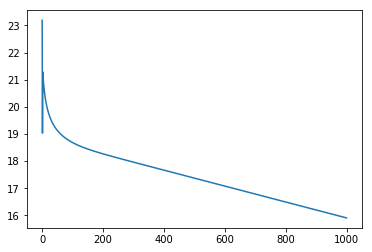

In [32]:
plt.plot(np.log(np.absolute(g_heat_evol[29])))
plt.show()

### Part 2: regularize weights and x if necessary

In [ ]:
#w_init, s_init, g_heat_init, sigma_s_init, sigma_g_init, x_init, s_evol, g_heat_evol, sigma_s_star_2_evol, sigma_g_star_2_evol

In [34]:
ESS_0=1/sum(np.square(w_init))
print(ESS_0*1000)

#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])

if ESS_0 <0.001*M:
    x[0,:]=x_init
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_init,w_init)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_init
    w[0,:]=w_init

1.0


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [37]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = -sigma_s_prev / sigma_s_star_2_evol , b = np.inf, loc= 0, scale = sigma_s_star_2_evol, size=M)[0]
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)[0]
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_star_2_evol , b = np.inf, loc= 0, scale = sigma_g_star_2_evol, size=M)[0]
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =g_h_prev / sigma_g, loc= 0, scale = sigma_g, size=M)[0]
    g_h=g_h_prev+err
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g


In [43]:
x_season(df.daytype[1],kappa,s_init,sigma_s_init)[0][:10]

array([  6.10233944e+63,   6.10233944e+63,   6.10233944e+63,
         6.10233944e+63,   6.10233944e+63,   6.10233944e+63,
         6.10233944e+63,   6.10233944e+63,   6.10233944e+63,
         6.10233944e+63])

In [39]:
x_heat(g_heat_init,31,sigma_g_init)[0][:10]

array([  7.64213372e+14,   7.64213008e+14,   7.64213057e+14,
         7.64213048e+14,   7.64213041e+14,   7.64213036e+14,
         7.64213033e+14,   7.64213030e+14,   7.64213027e+14,
         7.64213025e+14])

In [57]:
s=s_init
g_h=g_heat_init
sigma_s=sigma_s_init
sigma_g=sigma_g_init
n_iter=30
ESS=[]

for n in range(1,6):
    print("n=",n)
    x[n,:]=x_season(df.daytype[n+n_iter],kappa,s,sigma_s)[0]+x_heat(g_h,n+n_iter,sigma_g)[0]
    #take new current values of parameters
    s, sigma_s=x_season(df.daytype[n+n_iter],kappa,s,sigma_s)[1:]
    g_h, sigma_g=x_heat(g_h,n,sigma_g)[1:]
    #compute weights
    w_=w[n-1,:]*(x[n,:]+npr.normal(0,sigma2,size=M))
    wh=w_/sum(w_)
    ESS.append(1/sum(np.square(wh)))  #calculate ESS
    print(ESS[n-1])
    #regularization
    if ESS[n-1] <0.001*M:
        #x[n,:]=x_0
        w[n,:]=np.ones(M)*(1/M)  #reset the weights
    if (ESS[n-1]>=0.001*M and ESS_0<0.5*M):
        x_temp=resid_resample(x[n-1,:],w[n-1,:])
        w_temp=np.ones(M)*(1/M)
        x[n,:]=regul(x_temp,w_temp)
        w[n,:]=w_temp
    if ESS[n-1]>=0.5*M:
        x[n,:]=x[n-1,:]
        w[n,:]=w[n-1,:]

n= 1
0.622532897104
n= 2
0.153052288981
n= 3
1.97344131576
n= 4
0.0222966849147
n= 5
0.00120174865


In [61]:
ESS

[0.62253289710370252,
 0.15305228898109849,
 1.9734413157646979,
 0.022296684914656247,
 0.0012017486500011919]